In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from tqdm import tqdm
import copy

In [ ]:
# Loading and prepping data
base_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/"

urls = [
    "processed.cleveland.data",
    "processed.hungarian.data",
    "processed.switzerland.data",
    "processed.va.data"
]

dfs = []

columns = [
 'age','sex','cp','trestbps','chol','fbs','restecg',
 'thalach','exang','oldpeak','slope','ca','thal','target'
]
for url in urls:
    df_temp = pd.read_csv(base_url + url, names=columns, na_values='?')
    dfs.append(df_temp)

df = pd.concat(dfs, ignore_index=True)
df = df.apply(pd.to_numeric, errors='coerce')

from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")
df[columns] = imputer.fit_transform(df[columns])
df['target'] = (df['target'] > 0).astype(int)

print(f"Dataset shape: {df.shape}")
print(f"Class distribution:\n{df['target'].value_counts()}")

Dataset shape: (920, 14)
Class distribution:
target
1    509
0    411
Name: count, dtype: int64


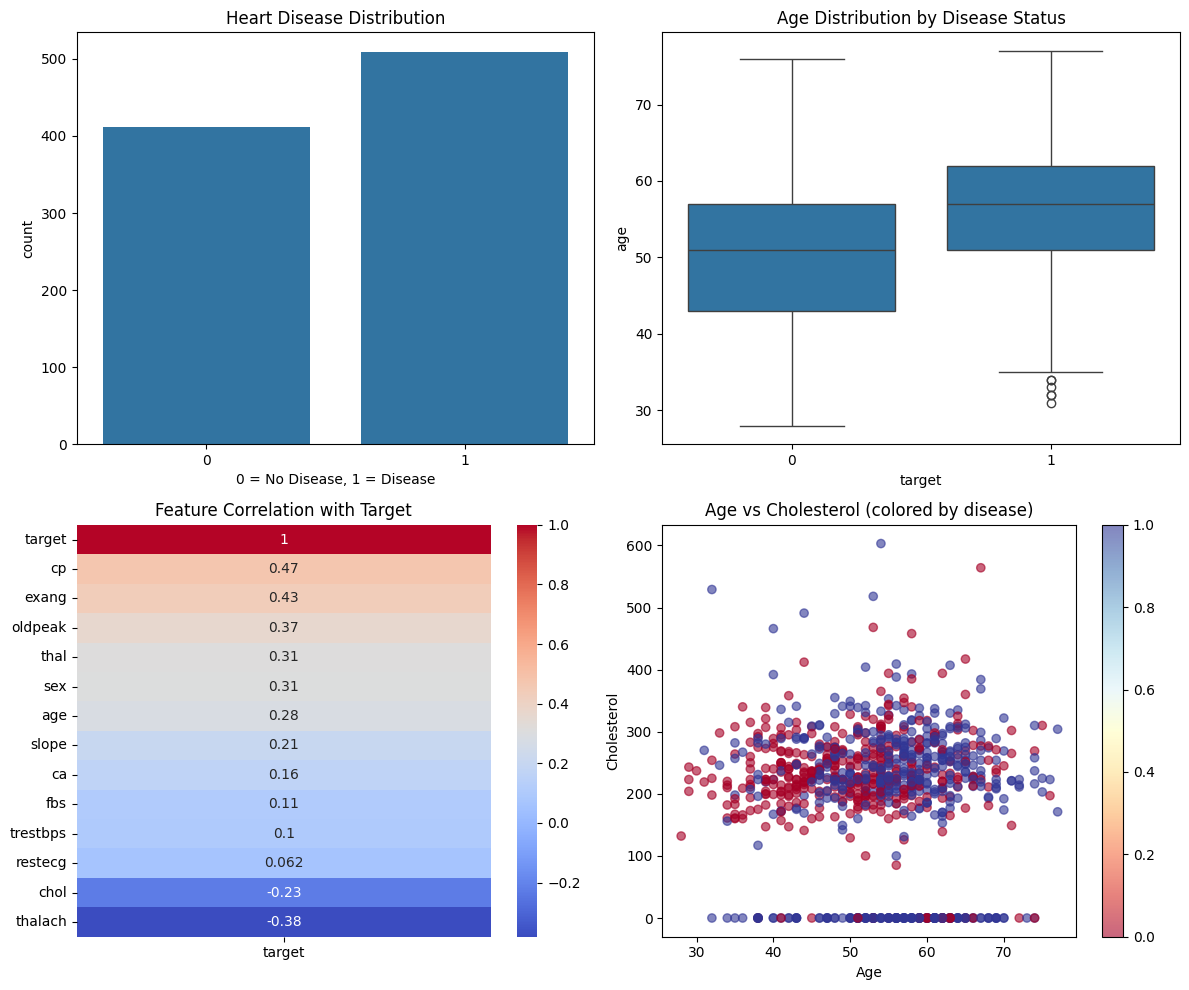

In [ ]:
# Visualizing the data
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Class distribution
sns.countplot(data=df, x='target', ax=axes[0, 0])
axes[0, 0].set_title('Heart Disease Distribution')
axes[0, 0].set_xlabel('0 = No Disease, 1 = Disease')

# Age distribution by target
sns.boxplot(data=df, x='target', y='age', ax=axes[0, 1])
axes[0, 1].set_title('Age Distribution by Disease Status')

# Correlation heatmap
correlation = df.corr()
sns.heatmap(correlation[['target']].sort_values(by='target', ascending=False),
            annot=True, cmap='coolwarm', ax=axes[1, 0], cbar=True)
axes[1, 0].set_title('Feature Correlation with Target')

# Cholesterol vs Age
scatter = axes[1, 1].scatter(df['age'], df['chol'], c=df['target'],
                             cmap='RdYlBu', alpha=0.6)
axes[1, 1].set_xlabel('Age')
axes[1, 1].set_ylabel('Cholesterol')
axes[1, 1].set_title('Age vs Cholesterol (colored by disease)')
plt.colorbar(scatter, ax=axes[1, 1])

plt.tight_layout()
plt.show()

In [ ]:
# Prepare Data with Proper Scaling
X = df.drop('target', axis=1).values
y = df['target'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test)

# Create datasets and loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

Training samples: 736
Test samples: 184


In [ ]:
class HeartDiseaseNet(nn.Module):
    def __init__(self, input_size):
        super(HeartDiseaseNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 32)
        self.bn1 = nn.BatchNorm1d(32)
        self.dropout1 = nn.Dropout(0.2)

        self.fc2 = nn.Linear(32, 16)
        self.bn2 = nn.BatchNorm1d(16)
        self.dropout2 = nn.Dropout(0.2)

        self.fc_out = nn.Linear(16, 2)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout2(x)

        x = self.fc_out(x)
        return x

# Initialize model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = HeartDiseaseNet(input_size=X_train.shape[1]).to(device)
# class weights to slightly correct the imbalance (use y_train already defined)
class_counts = np.bincount(y_train)
total = len(y_train)
class_weights = total / (2.0 * class_counts)   # inverse frequency
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-3)

print("Class counts (train):", class_counts)
print("Class weights:", class_weights.detach().cpu().numpy())

print(f"Using device: {device}")
print(f"\nModel Architecture:\n{model}")

Class counts (train): [329 407]
Class weights: [1.118541  0.9041769]
Using device: cpu

Model Architecture:
HeartDiseaseNet(
  (fc1): Linear(in_features=13, out_features=32, bias=True)
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (bn2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc_out): Linear(in_features=16, out_features=2, bias=True)
)


In [ ]:
def train_function(model, train_loader, test_loader, epochs, optimizer, criterion):

    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    best_state = None
    best_test_loss = float('inf')
    patience = 10
    patience_counter = 0

    for epoch in tqdm(range(epochs)):
        # Training phase
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # Forward pass
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            train_total += y_batch.size(0)
            train_correct += (predicted == y_batch).sum().item()

        # Validation phase
        model.eval()
        test_loss = 0
        test_correct = 0
        test_total = 0

        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)

                test_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                test_total += y_batch.size(0)
                test_correct += (predicted == y_batch).sum().item()

        # Record metrics
        train_loss /= len(train_loader)
        test_loss /= len(test_loader)
        train_acc = train_correct / train_total
        test_acc = test_correct / test_total

        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)

        # Print every 20 epochs (same as before)
        if (epoch + 1) % 20 == 0:
            print(f'\nEpoch [{epoch+1}/{epochs}]')
            print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
            print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

        # Early stopping on test loss
        if test_loss < best_test_loss - 1e-4:
            best_test_loss = test_loss
            best_state = copy.deepcopy(model.state_dict())
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'\nEarly stopping at epoch {epoch+1}')
                break

    # Load best weights
    if best_state is not None:
        model.load_state_dict(best_state)

    return train_losses, test_losses, train_accuracies, test_accuracies

In [ ]:
train_losses, test_losses, train_accs, test_accs = train_function(
    model, train_loader, test_loader, epochs=100, optimizer=optimizer, criterion=criterion
)


 22%|██▏       | 22/100 [00:01<00:05, 13.40it/s]


Epoch [20/100]
Train Loss: 0.4168, Train Acc: 0.8274
Test Loss: 0.4027, Test Acc: 0.8370


 42%|████▏     | 42/100 [00:03<00:04, 14.34it/s]


Epoch [40/100]
Train Loss: 0.3841, Train Acc: 0.8533
Test Loss: 0.3747, Test Acc: 0.8424


 46%|████▌     | 46/100 [00:03<00:04, 12.55it/s]


Early stopping at epoch 47


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor.to(device))
    _, preds = torch.max(outputs, 1)
    y_pred = preds.cpu().numpy()

print(classification_report(y_test, y_pred, digits=4))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0     0.8415    0.8415    0.8415        82
           1     0.8725    0.8725    0.8725       102

    accuracy                         0.8587       184
   macro avg     0.8570    0.8570    0.8570       184
weighted avg     0.8587    0.8587    0.8587       184

[[69 13]
 [13 89]]


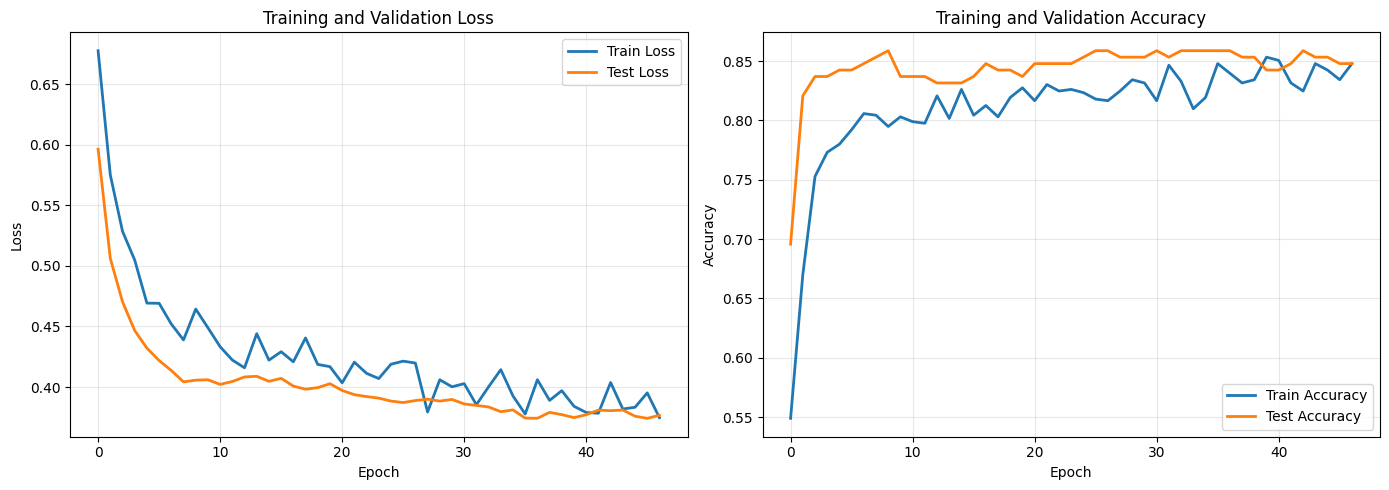

In [ ]:
# Plot Training Metrics
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
axes[0].plot(train_losses, label='Train Loss', linewidth=2)
axes[0].plot(test_losses, label='Test Loss', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy plot
axes[1].plot(train_accs, label='Train Accuracy', linewidth=2)
axes[1].plot(test_accs, label='Test Accuracy', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Comprehensive Evaluation
model.eval()
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        probs = F.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y_batch.numpy())
        all_probs.extend(probs[:, 1].cpu().numpy())

accuracy = sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)
print(f'FINAL TEST ACCURACY: {accuracy:.4f} ({accuracy*100:.2f}%)')

FINAL TEST ACCURACY: 0.8587 (85.87%)


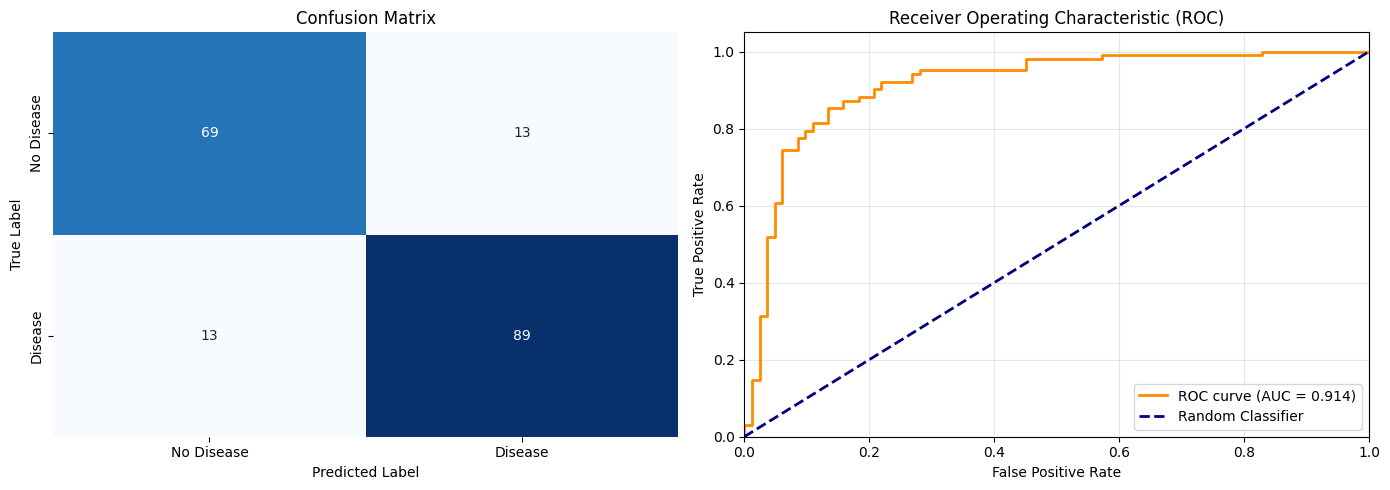


Classification Report:
              precision    recall  f1-score   support

  No Disease       0.84      0.84      0.84        82
     Disease       0.87      0.87      0.87       102

    accuracy                           0.86       184
   macro avg       0.86      0.86      0.86       184
weighted avg       0.86      0.86      0.86       184



In [ ]:
# Confusion Matrix and Classification Report
cm = confusion_matrix(all_labels, all_preds)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[0],
            xticklabels=['No Disease', 'Disease'],
            yticklabels=['No Disease', 'Disease'])
axes[0].set_title('Confusion Matrix')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# ROC Curve
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('Receiver Operating Characteristic (ROC)')
axes[1].legend(loc="lower right")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nClassification Report:")
print(classification_report(all_labels, all_preds,
                          target_names=['No Disease', 'Disease']))

/tmp/ipython-input-3530013888.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')


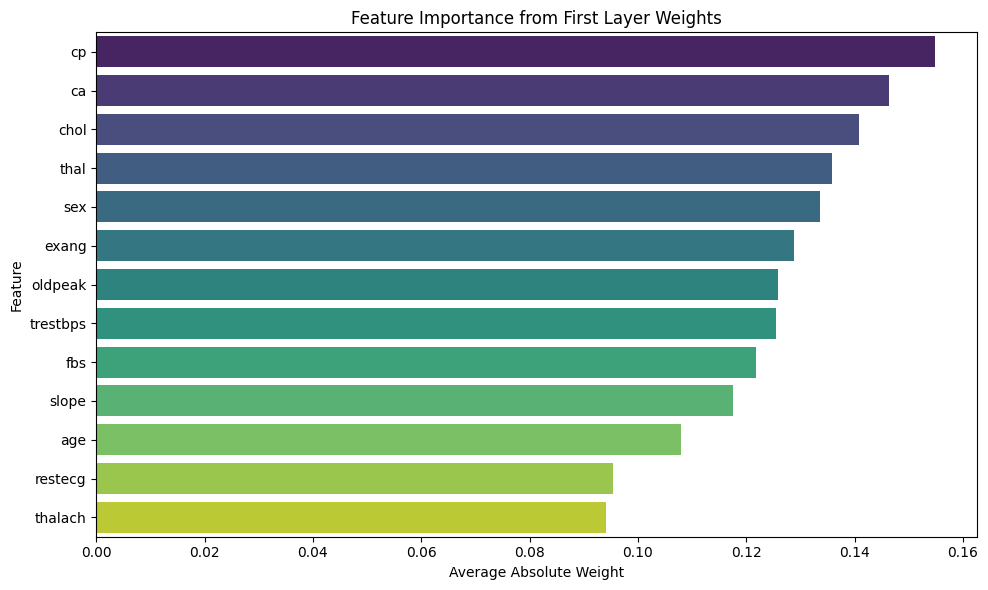


Top 5 Most Important Features:
   Feature  Importance
2       cp    0.154928
11      ca    0.146337
4     chol    0.140775
12    thal    0.135771
1      sex    0.133661


In [ ]:
# Feature Importance Analysis
# Extract weights from first layer
weights = model.fc1.weight.data.cpu().abs().mean(dim=0).numpy()
feature_names = columns[:-1]  # All features except target

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': weights
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')
plt.title('Feature Importance from First Layer Weights')
plt.xlabel('Average Absolute Weight')
plt.tight_layout()
plt.show()

print("\nTop 5 Most Important Features:")
print(importance_df.head())

In [ ]:
# Model Summary Statistics
print("MODEL PERFORMANCE SUMMARY")
print(f"Model Architecture: 5-layer Neural Network")
print(f"Input Features: {X_train.shape[1]}")
print(f"Hidden Layers: [128, 64, 32, 16]")
print(f"Output Classes: 2 (No Disease, Disease)")
print(f"Batch Normalization: Yes")
print(f"Dropout Rate: 0.3")
print(f"Optimizer: Adam (lr=0.001)")
print(f"Loss Function: CrossEntropyLoss")
print(f"\nTraining Epochs: 100")
print(f"Final Train Accuracy: {train_accs[-1]:.4f}")
print(f"Final Test Accuracy: {test_accs[-1]:.4f}")
print(f"AUC Score: {roc_auc:.4f}")

MODEL PERFORMANCE SUMMARY
Model Architecture: 5-layer Neural Network
Input Features: 13
Hidden Layers: [128, 64, 32, 16]
Output Classes: 2 (No Disease, Disease)
Batch Normalization: Yes
Dropout Rate: 0.3
Optimizer: Adam (lr=0.001)
Loss Function: CrossEntropyLoss

Training Epochs: 100
Final Train Accuracy: 0.8478
Final Test Accuracy: 0.8478
AUC Score: 0.9142
